In [1]:
import torch 
import torch.nn as nn
import numpy as np

from ANFISpy import RANFIS

ModuleNotFoundError: No module named 'ANFISpy'

In [2]:
class GaussianMF(nn.Module):
    def __init__(self, n_sets, uod):
        '''Gaussian membership function. Receives the input tensor of a variable and outputs the tensor with the membership            
        values.

        Args:
            n_sets:      int for number of fuzzy sets associated to the variable.
            uod:         list/tuple with the universe of discourse of the variable.

        Tensors:
            x:           tensor (N) containing the inputs of a variable.
            mu:          tensor (n) representing the mu parameter for the gaussian set (opt).
            sigma:       tensor (n) representing the sigma parameter for the gaussian set (opt).
            memberships: tensor (N, n) containing the membership values of the inputs.
        '''

        super(GaussianMF, self).__init__()

        self.n_sets = n_sets
        self.uod = uod
        
        step = ((uod[1] - uod[0]) / (n_sets - 1))
        
        self.mu = nn.Parameter(torch.linspace(*uod, n_sets))
        self.sigma = nn.Parameter((step / 2) * torch.ones(n_sets))

    def forward(self, x):
        x = x.reshape(-1, 1).repeat(1, self.n_sets)
        
        mu = torch.minimum(torch.maximum(self.mu, torch.tensor(self.uod[0])), torch.tensor(self.uod[1]))
        sigma = nn.functional.relu(self.sigma) + 1e-6
        
        memberships = torch.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
        
        return memberships
    
class TriangularMF(nn.Module):
    def __init__(self, n_sets, uod):
        '''Triangular membership function. Receives the input tensor of a variable and outputs the tensor with the                      
        membership values.

        Args:
            n_sets: int for number of fuzzy sets associated to the variable.
            uod:    list/tuple with the universe of discourse of the variable.

        Tensors:
            x:      tensor (N) containing the inputs of a variable.
            a:      tensor (N) containing the left point of the triangle (opt).
            b:      tensor (N) containing the center point of the triangle (opt).
            c:      tensor (N) containing the right point of the triangle (opt).
        '''

        super(TriangularMF, self).__init__()

        self.n_sets = n_sets
        self.uod = uod
        
        step = ((uod[1] - uod[0]) / (n_sets - 1))
        
        self.b = nn.Parameter(torch.linspace(*uod, n_sets))
        self.deltaL = nn.Parameter(step * torch.ones(n_sets))
        self.deltaR = nn.Parameter(step * torch.ones(n_sets))

    def forward(self, x, delta=10e-8):
        x = x.reshape(-1, 1).repeat(1, self.n_sets)
        
        b = torch.minimum(torch.maximum(self.b, torch.tensor(self.uod[0])), torch.tensor(self.uod[1]))
        deltaL = nn.functional.relu(self.deltaL) + 1e-6
        deltaR = nn.functional.relu(self.deltaR) + 1e-6

        left = (x + deltaL - b) / (deltaL + delta)
        right = (deltaR + b - x) / (deltaR + delta)
        
        memberships = torch.maximum(torch.minimum(left, right), torch.tensor(0.0))
        
        return memberships

class BellMF(nn.Module):
    def __init__(self, n_sets, uod):
        '''Generalized bell membership function. Receives the input tensor of a variable and outputs the tensor with the 
        membership values.

        Args:
            n_sets:      int for number of fuzzy sets associated to the variable.
            uod:         list/tuple with the universe of discourse of the variable.

        Tensors:
            x:           tensor (N) containing the inputs of a variable.
            a:           tensor (n) representing the a parameter for the bell set (opt).
            b:           tensor (n) representing the b parameter for the bell set (opt).
            c:           tensor (n) representing the c parameter for the bell set (opt).
            memberships: tensor (N, n) containing the membership values of the inputs.
        '''

        super(BellMF, self).__init__()

        self.n_sets = n_sets
        self.uod = uod
        
        step = ((uod[1] - uod[0]) / (n_sets - 1))
        
        self.c = nn.Parameter(torch.linspace(*uod, n_sets))
        self.a = nn.Parameter((step / 2) * torch.ones(n_sets))
        self.b = nn.Parameter(step * torch.ones(n_sets))

    def forward(self, x):
        x = x.reshape(-1, 1).repeat(1, self.n_sets)
        
        c = torch.minimum(torch.maximum(self.c, torch.tensor(self.uod[0])), torch.tensor(self.uod[1]))
        a = nn.functional.relu(self.a) + 1e-6
        b = nn.functional.relu(self.b) + 1e-6
        
        memberships = 1 / (1 + torch.abs((x - c) / (a)) ** (2 * b))
        
        return memberships
    
class SigmoidMF(nn.Module):
    def __init__(self, n_sets, uod):
        '''Sigmoid membership function. Receives the input tensor of a variable and outputs the tensor with the 
        membership values.

        Args:
            n_sets:      int for number of fuzzy sets associated to the variable.
            uod:         list/tuple with the universe of discourse of the variable.

        Tensors:
            x:           tensor (N) containing the inputs of a variable.
            a:           tensor (n) representing the a parameter for the sigmoid set (opt).
            c:           tensor (n) representing the c parameter for the sigmoid set (opt).
            memberships: tensor (N, n) containing the membership values of the inputs.
        '''

        super(SigmoidMF, self).__init__()

        self.n_sets = n_sets
        self.uod = uod
        
        step = ((uod[1] - uod[0]) / (n_sets - 1))
        delta = uod[1] - uod[0]
    
        self.c = nn.Parameter(torch.linspace(uod[0] + 0.05 * delta, uod[1] - 0.05 * delta, n_sets))
        self.a = nn.Parameter(2 * step * torch.ones(n_sets))

    def forward(self, x):
        x = x.reshape(-1, 1).repeat(1, self.n_sets)
        
        c = torch.minimum(torch.maximum(self.c, torch.tensor(self.uod[0])), torch.tensor(self.uod[1]))
        
        memberships = 1 / (1 + torch.exp(- self.a * (x - c)))
        
        return memberships

In [49]:
import itertools

class Antecedents(nn.Module):
    def __init__(self, n_sets, and_operator, mean_rule_activation=False):
        '''Calculates the antecedent values of the rules. Makes all possible combinations from the fuzzy sets defined for              
        each variable, considering rules of the form: var1 is set1 and ... and varn is setn.

        Args:
            n_sets:               list with the number of fuzzy sets associated to each variable.
            and_operator:         torch function for agregation of the membership values, modeling the AND operator.
            mean_rule_activation: bool to keep mean rule activation values.

        Tensors:
            memberships:          tensor (n) with tensors (N, nj) containing the membership values of each variable.
            weight:               tensor (N) representing the activation weights of a certain rule for all inputs.
            antecedents:          tensor (N, R) with the activation weights for all rules.
        '''

        super(Antecedents, self).__init__()

        self.n_sets = n_sets
        self.n_rules = torch.prod(torch.tensor(n_sets))
        self.and_operator = and_operator
        self.combinations = list(itertools.product(*[range(i) for i in n_sets]))
        self.mean_rule_activation = []
        self.bool = mean_rule_activation

    def forward(self, memberships):
        N = memberships[0].size(0)
        antecedents = []

        for combination in self.combinations:
            mfs = [] 
            
            for var_index, set_index in enumerate(combination):
                mfs.append(memberships[var_index][:, set_index])
            
            weight = self.and_operator(torch.stack(mfs, dim=1), dim=1)
            
            if isinstance(weight, tuple):  
                weight = weight[0]  
            
            antecedents.append(weight)

        antecedents = torch.stack(antecedents, dim=1)
        
        if self.bool:
            with torch.no_grad():
                self.mean_rule_activation.append(torch.mean(antecedents, dim=0))    
            
        return antecedents
    
class ConsequentsRegression(nn.Module):
    def __init__(self, n_sets):
        '''Calculates the consequent values of the system for a regression problem, considering a linear combination of the            
        input variables.

        Args:
            n_sets:       list with the number of fuzzy sets associated to each variable.

        Tensors:
            x:            tensor (N, n) containing the inputs of a variable.
            A:            tensor (R, n) with the linear coefficients (opt).
            b:            tensor (R) with the bias coefficients (opt).
            consequents:  tensor (N, R) containing the consequents of each rule.
        '''

        super(ConsequentsRegression, self).__init__()

        n_vars = len(n_sets)
        n_rules = torch.prod(torch.tensor(n_sets))

        self.A = nn.Parameter(torch.randn(n_rules, n_vars))
        self.b = nn.Parameter(torch.randn(n_rules))

    def forward(self, x):
        consequents = x @ self.A.T + self.b 
        return consequents
    
class ConsequentsClassification(nn.Module):
    def __init__(self, n_sets, n_classes):
        '''Calculates the consequent values of the system for a classification problem, considering a linear combination of            
        the input variables.

        Args:
            n_sets:       list with the number of fuzzy sets associated to each variable.
            n_classes:    int with number of n_classes.

        Tensors:
            x:            tensor (N, n) containing the inputs of a variable.
            A:            tensor (R, m, n) with the linear coefficients (opt).
            b:            tensor (R, m) with the bias coefficients (opt).
            consequents:  tensor (R, N, m) containing the consequents of each rule.
        '''

        super(ConsequentsClassification, self).__init__()

        n_vars = len(n_sets)
        n_rules = torch.prod(torch.tensor(n_sets))

        self.A = nn.Parameter(torch.randn(n_rules, n_classes, n_vars))
        self.b = nn.Parameter(torch.randn(n_rules, n_classes))

    def forward(self, x):
        consequents = torch.matmul(self.A, x.T).permute(0, 2, 1) + self.b.unsqueeze(1)
        return consequents

class RecurrentInferenceRegression(nn.Module):
    def __init__(self, output_activation=nn.Identity()):
        '''Performs the Takagi-Sugeno-Kang inference for RANFIS in a regression problem.
        
        Args:
            output_activation: torch activation function.
        
        Tensors:
            antecedents:       tensor (N, R) with the weights of activation of each rule.
            consequents:       tensor (N, R) with the outputs of each rule.
            h:                 tensor (R) with hidden state.
            Y:                 tensor (N) with the outputs of the system.
            output_activation: torch function.
        '''
        
        super(RecurrentInferenceRegression, self).__init__()
        
        self.output_activation = output_activation

    def forward(self, antecedents, consequents, h):
        weights = antecedents / torch.sum(antecedents, dim=1, keepdim=True) 
        Y = torch.sum(weights * (consequents + h), dim=1, keepdim=True) 
        Y = self.output_activation(Y)
        return Y
    
class RecurrentInferenceClassification(nn.Module):
    def __init__(self, output_activation=nn.Identity()):
        '''Performs the Takagi-Sugeno-Kang inference for RANFIS in a classification problem.

        Args:
            output_activation: torch activation function.

        Tensors:
            antecedents: tensor (N, R) with the weights of activation of each rule.
            consequents: tensor (R, N, m) with the outputs of each rule.
            h:           tensor (R) with hidden state.
            Y:           tensor (N, m) with the outputs of the system.
        '''

        super(RecurrentInferenceClassification, self).__init__()

        self.output_activation = output_activation
        
    def forward(self, antecedents, consequents, h):
        weights = antecedents / torch.sum(antecedents, dim=1, keepdim=True)
        consequents += h
        Y = torch.sum(weights.unsqueeze(-1) * consequents.transpose(0, 1), dim=1)
        return self.output_activation(Y)

class RecurrentLayerRegression(nn.Module):
    def __init__(self, n_rules, activation=nn.Tanh()):
        '''Updates the hidden state vector of a RANFIS for regression.

        Args:
            n_rules:     int for number of rules in RANFIS.
            activation:  torch activation function.

        Tensors:
            consequents: tensor (N, R) with the outputs of each rule.
            h_old:       tensor (N, R) with old hidden state.
            U:           tensor (R, R) with weights for transforming old hidden state. (Opt.)
            b:           tensor (R) with bias for the new hidden state. (Opt.)
            h_new:       tensor (N, R) with new hidden state.
        '''
        
        super(RecurrentLayerRegression, self).__init__()

        self.activation = activation
        self.U = nn.Parameter(torch.randn(n_rules, n_rules))
        self.b = nn.Parameter(torch.randn(n_rules))
        
    def forward(self, consequents, h_old):
        h_new = h_old @ self.U + consequents + self.b 
        return self.activation(h_new)

class RecurrentLayerClassification(nn.Module):
    def __init__(self, n_rules, activation=nn.Tanh()):
        '''Updates the hidden state vector of a RANFIS for classification.

        Args:
            n_rules:     int for number of rules in RANFIS.
            activation:  torch activation function.

        Tensors:
            consequents: tensor (R, N, m) with the outputs of each rule.
            h_old:       tensor (R, N, m) with old hidden state.
            U:           tensor (R, R) with weights for transforming old hidden state (opt.).
            b:           tensor (R) with bias for the new hidden state (opt.).
            h_new:       tensor (R, N, m) with new hidden state.
        '''

        super(RecurrentLayerClassification, self).__init__()

        self.activation = activation
        self.U = nn.Parameter(torch.randn(n_rules, n_rules))
        self.b = nn.Parameter(torch.randn(n_rules))
        
    def forward(self, consequents, h_old):
        h_new = (h_old.transpose(0, -1) @ self.U).transpose(0, -1) + consequents + self.b.view(-1, 1, 1) 
        return self.activation(h_new)

In [40]:
days = np.linspace(0, 1, 500)
mean_cases_day = np.sin(days * 50) * np.exp(- days)

def create_sequences(data, time, seq_length):
    X, y, time_labels = [], [], []
    for i in range(len(data) - seq_length): 
        X.append(data[i : i + seq_length])  
        y.append(data[i + seq_length])      
        time_labels.append(time[i + seq_length])  
    return np.array(X), np.array(y), np.array(time_labels)

seq_length = 10  
X, y, prediction_days = create_sequences(mean_cases_day, days, seq_length)

X = torch.FloatTensor(X).unsqueeze(2)  
y = torch.FloatTensor(y).unsqueeze(1) 

train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train, days_train = X[:train_size], y[:train_size], prediction_days[:train_size]
X_val, y_val, days_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size], prediction_days[train_size:train_size+val_size]
X_test, y_test, days_test = X[train_size+val_size:], y[train_size+val_size:], prediction_days[train_size+val_size:]

In [42]:
n_vars = 1
mf_names = [['L', 'M', 'H']]

variables = {
    'inputs': {
        'n_sets': [5],
        'uod': n_vars * [(0, 1)],
        'var_names': ['var1'],
        'mf_names': n_vars * mf_names,
    },
    'output': {
        'var_names': 'out',
        'n_classes': 1,
    },
}

model = RANFIS(variables, 'bell', output_activation=nn.Identity())

Number of parameters: 55


In [43]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs, _ = model(X_train)
    loss_train = criterion(outputs, y_train)
    loss_train.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        outputs, _ = model(X_val)
        loss_val = criterion(outputs, y_val)
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch} | Train Loss: {loss_train.item():.5f} | Validation Loss: {loss_val.item():.5f}')

Epoch 0 | Train Loss: 0.62235 | Validation Loss: 0.28697
Epoch 50 | Train Loss: 0.01780 | Validation Loss: 0.02004
Epoch 100 | Train Loss: 0.00284 | Validation Loss: 0.00258
Epoch 150 | Train Loss: 0.00127 | Validation Loss: 0.00105
Epoch 200 | Train Loss: 0.00075 | Validation Loss: 0.00070
Epoch 250 | Train Loss: 0.00059 | Validation Loss: 0.00053
Epoch 300 | Train Loss: 0.00039 | Validation Loss: 0.00031
Epoch 350 | Train Loss: 0.00034 | Validation Loss: 0.00024
Epoch 400 | Train Loss: 0.00030 | Validation Loss: 0.00022
Epoch 450 | Train Loss: 0.00026 | Validation Loss: 0.00021


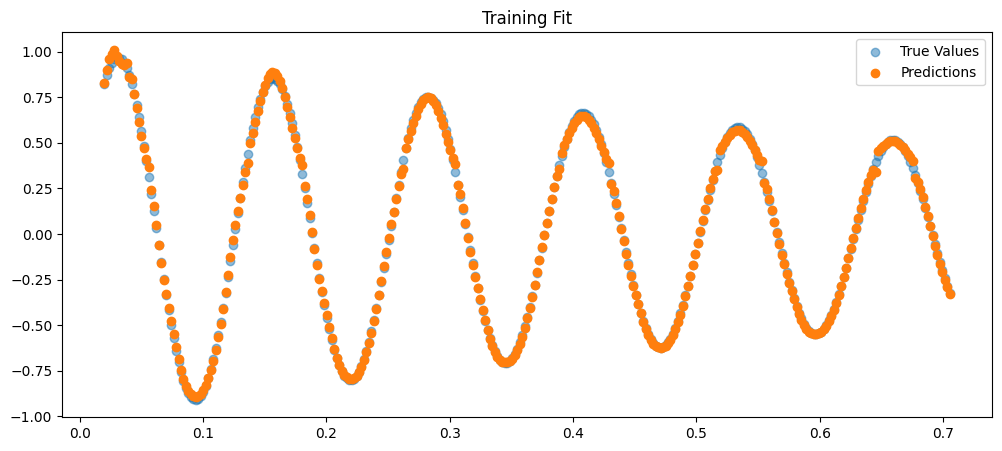

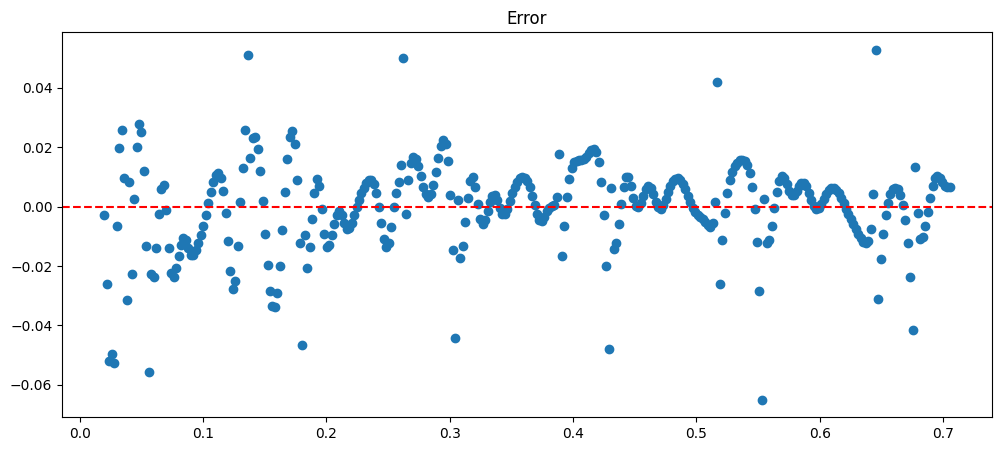

In [44]:
import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    train_predictions = model(X_train)[0].numpy().flatten()
    
plt.figure(figsize=(12, 5))
plt.scatter(days_train, y_train.numpy(), label='True Values', alpha=0.5)
plt.scatter(days_train, train_predictions, label='Predictions')
plt.legend()
plt.title("Training Fit")
plt.show()

plt.figure(figsize=(12, 5))
plt.scatter(days_train, y_train.numpy().flatten() - train_predictions)
plt.axhline(0, c='red', linestyle='--')
plt.title('Error')
plt.show()

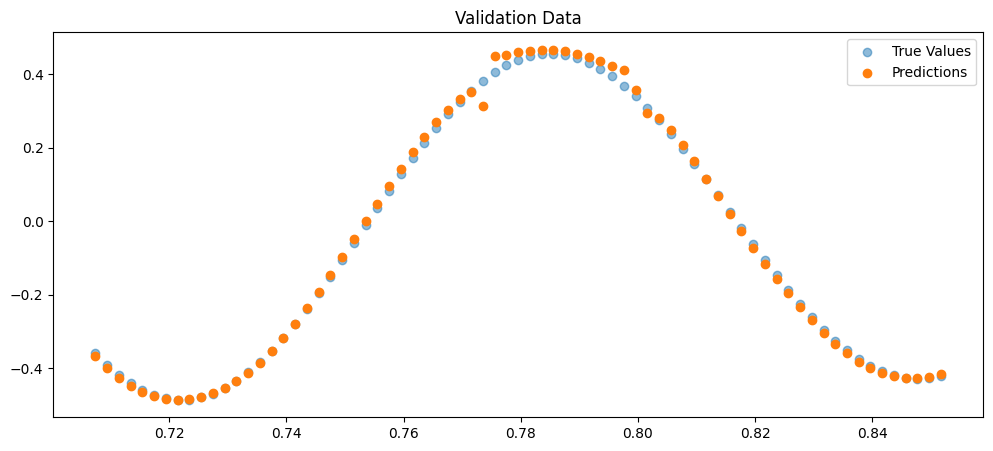

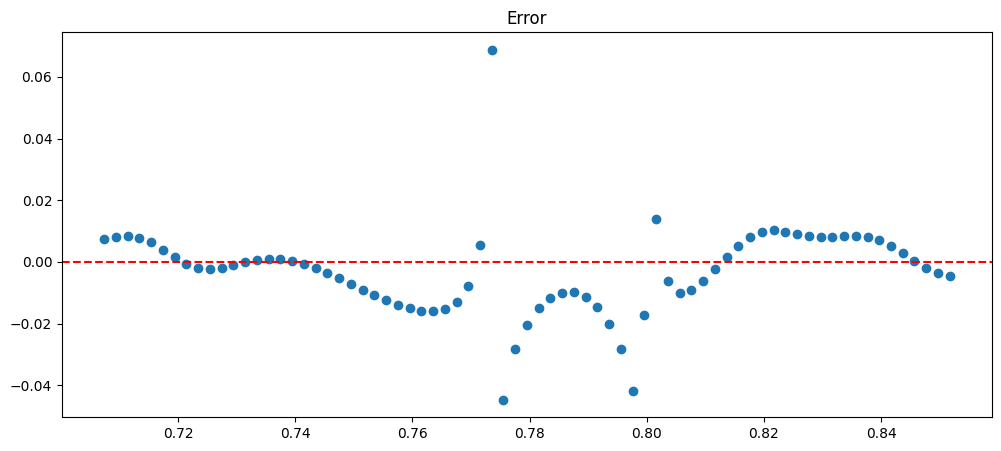

In [45]:
model.eval()
with torch.no_grad():
    val_predictions = model(X_val)[0].numpy().flatten()
    
plt.figure(figsize=(12, 5))
plt.scatter(days_val, y_val.numpy(), label='True Values', alpha=0.5)
plt.scatter(days_val, val_predictions, label='Predictions')
plt.legend()
plt.title("Validation Data")
plt.show()

plt.figure(figsize=(12, 5))
plt.scatter(days_val, y_val.numpy().flatten() - val_predictions)
plt.axhline(0, c='red', linestyle='--')
plt.title('Error')
plt.show()

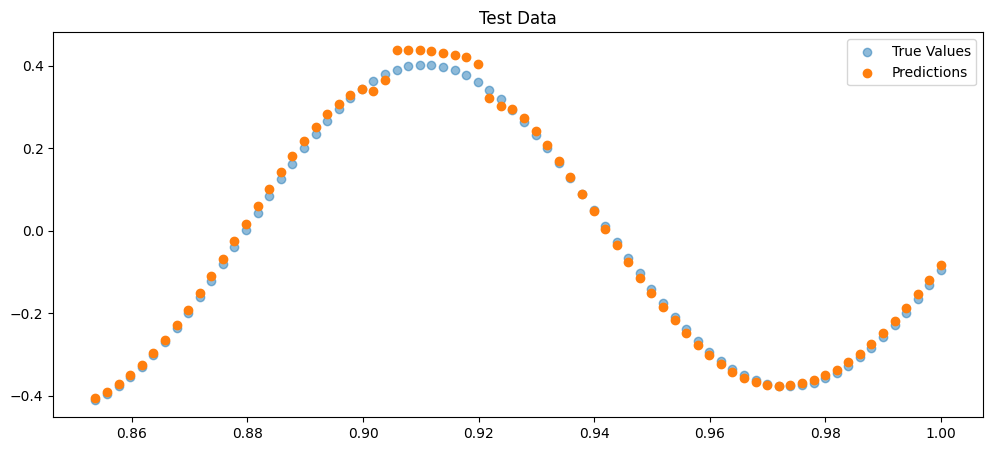

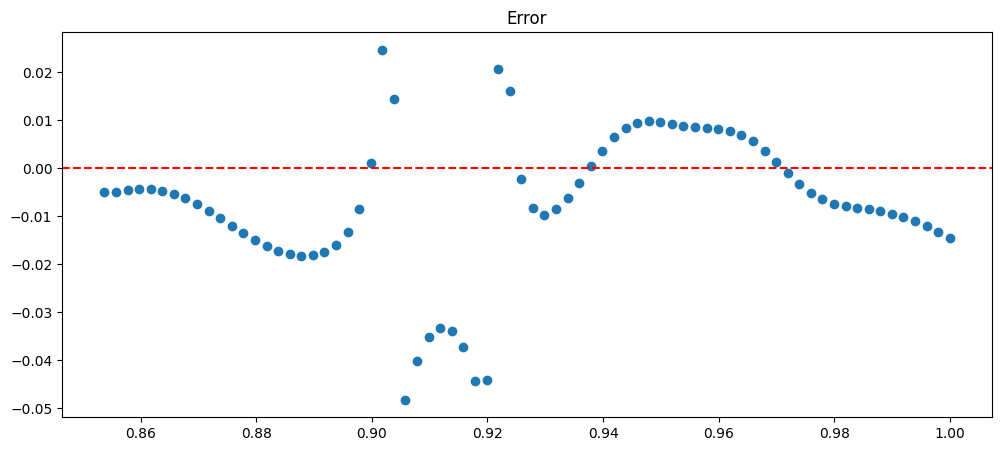

In [46]:
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)[0].numpy().flatten()
    
plt.figure(figsize=(12, 5))
plt.scatter(days_test, y_test.numpy(), label='True Values', alpha=0.5)
plt.scatter(days_test, test_predictions, label='Predictions')
plt.legend()
plt.title("Test Data")
plt.show()

plt.figure(figsize=(12, 5))
plt.scatter(days_test, y_test.numpy().flatten() - test_predictions)
plt.axhline(0, c='red', linestyle='--')
plt.title('Error')
plt.show()